In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
import time

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
from skimage import restoration

%matplotlib inline
t1 = time.time()

In [2]:
##
## Read necessary files and folders 
train_audio_path = '../input/freesound-audio-tagging-2019/train_curated/'
train_files = os.listdir(train_audio_path)
train_annot = pd.read_csv('../input/freesound-audio-tagging-2019/train_curated.csv')
test_audio_path = '../input/freesound-audio-tagging-2019/test/'
test_files = np.sort(os.listdir(test_audio_path))
print (test_files[:5])
##
## I 've created the weights in previous run. Just use them
USE_WEIGHTS = False
len(train_files), len(test_files)

['000ccb97.wav' '0012633b.wav' '001ed5f1.wav' '00294be0.wav'
 '003fde7a.wav']


(4970, 1120)

In [3]:
##
## Here we calculate unique labels (80) and create the necessary data structures
## for binary encoding the multi-labeled input
##
## label_dict : dictionary with classes as keys and counts per classes as values
##              {'Bark': 74, 'Raindrop': 74, 'Finger_snapping': 74, 'Run': 74, 'Whispering': 74, .... }
## classes: 80 sound classes 
##              ['Bark', 'Raindrop', 'Finger_snapping', 'Run', 'Whispering', ...]
## all_labels_set (size: 4970): List of sets. The same size as training sounds. Each set correspond to the classes of the i-th sound
##              [{'Bark'},  {'Raindrop'},  {'Finger_snapping'},  {'Run'},  {'Finger_snapping'},  {'Whispering'},  {'Acoustic_guitar', 'Strum'},  ...]
## first_labels_set (size: 4970) : List containing only first class for each training pattern..  to be used as approximation stratification 
##              ['Bark', 'Raindrop', 'Finger_snapping', 'Run', 'Finger_snapping', 'Whispering', 'Acoustic_guitar', ...]

##
## L = 1 * SAMPLE_RATE -> 1 second
## L = 2 * SAMPLE_RATE -> 2 seconds ....

SAMPLE_RATE  = 44100
L = int( 1.5 * SAMPLE_RATE )

def create_unique_labels(all_labels):
    label_dict = {}
    all_labels_set = []
    first_labels_set = []
    for labs in all_labels:
        lab = labs.split(',')
        for l in lab:
            if l in label_dict:
                label_dict[l] = label_dict[l]  + 1
            else:
                label_dict[l]= 0

        all_labels_set.append(set(lab))
        first_labels_set.append(lab[0])
    classes = list(label_dict.keys())
    
    return label_dict, classes, all_labels_set, first_labels_set

In [4]:
label_dict, classes, all_labels_set, first_labels_set = create_unique_labels(train_annot.labels)
files = train_annot.fname
print (len(files), len(train_files))

4970 4970


In [5]:
##
## Y_split are the binary labels used for stratification
## Y is the target
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
binarize = MultiLabelBinarizer(classes=classes)
encode = LabelEncoder()
Y_split = encode.fit_transform(first_labels_set)
Y = binarize.fit_transform(all_labels_set)

In [6]:
##
## Read all training files and keep them in memory
from tqdm import tqdm_notebook
X_raw = []
for f in tqdm_notebook(files):
    sample_rate, sample_ = wavfile.read(str(train_audio_path) + f)
    X_raw.append(sample_)

In [7]:
##
## Nice helper functions for padding, random sampling L samples

def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

# 150000 , 44100 ->  [0, .,......., (150000-44100)]
def chop_audio(samples):
    beg = np.random.randint(0, len(samples) - L)
    return samples[beg: beg + L]
        
        
def log_specgram(audio, 
                 sample_rate, 
                 window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    #print(nperseg)
    #noverlap = nperseg // 8
    noverlap = int(round(step_size * sample_rate / 1e3))
    #print(noverlap)
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.astype(np.float32) + eps)


    

In [8]:
xx = pad_audio(X_raw[15])
if len(xx) > L:
    xx = chop_audio(xx)
_, _, specgram = log_specgram(xx, sample_rate=SAMPLE_RATE,  window_size=10, step_size=5)
img_shape_from_spec = specgram.shape[0], specgram.shape[1], 1
print(img_shape_from_spec)

(221, 298, 1)


(221, 298, 1)


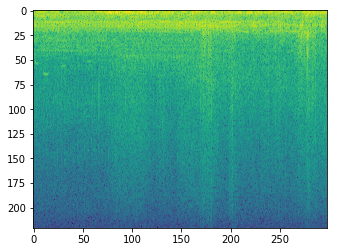

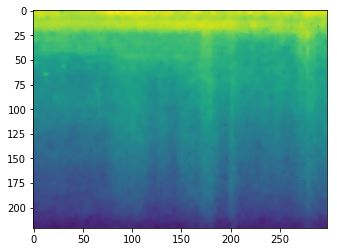

0.013617992401123047
0.00668787956237793


In [9]:
time5 = time.time()
_, _, specgram = log_specgram(xx, sample_rate=SAMPLE_RATE,  window_size=10, step_size=5)
time6 = time.time()
img_shape_from_spec = specgram.shape[0], specgram.shape[1], 1
print(img_shape_from_spec)
plt.imshow(specgram)
plt.show()
time3 = time.time()
new_image = restoration.denoise_tv_chambolle(specgram, weight=2, eps=0.0002, n_iter_max=200)
time4 = time.time()
plt.imshow(new_image)
plt.show()
print(time4-time3)
print(time6-time5)

In [10]:
##
## DataGenerator based on keras.utils.Sequence. The nice thing about it is the random part selection that works like augmentation.
## TestDataGenerator is bad software engineering from my part... Essentially the same generator used only for inference...

import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=img_shape_from_spec, n_channels=1,
                 n_classes=80, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        max_index = min((index+1)*self.batch_size, len(self.list_IDs))
        indexes = self.indexes[index*self.batch_size:max_index]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []# np.empty((self.batch_size, *self.dim, self.n_channels))
        y = []# np.empty((self.batch_size), dtype=int)
        #t1 = time.time()
        #print (list_IDs_temp)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            #print (i, ID)
            # Store samplw
            xx = X_raw[ID].copy()
    
            xx = pad_audio(xx)
            if len(xx) > L:
                xx = chop_audio(xx)
            _, _, specgram = log_specgram(xx, sample_rate=SAMPLE_RATE,  window_size=10, step_size=5)
            #X.append(restoration.denoise_tv_chambolle(specgram, weight=2, eps=0.0002, n_iter_max=200))
            X.append(specgram)

            # Store class
            y.append(self.labels[ID, :])
            
        #t2 = time.time()
        #print (t2-t1)
        y = np.array(y, dtype='float32')
        X = np.expand_dims(np.array(X), -1)
        return X, y

class TestDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, test_files, test_base_path, batch_size=32, dim=(256,256,1), n_channels=1,
                 n_classes=80):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.test_base_path = test_base_path
        self.test_files = test_files
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.test_files) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        max_index = min((index+1)*self.batch_size, len(self.test_files))
        indexes = self.indexes[index*self.batch_size:max_index]

        # Find list of IDs
        list_IDs_temp = [self.test_files[k] for k in indexes]

        # Generate data
        X = self.__data_generation(list_IDs_temp)

        return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.test_files))


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []# np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store samplw
            sample_rate, xx = wavfile.read(str(self.test_base_path) + ID)
            xx = pad_audio(xx)
            if len(xx) > L:
                xx = chop_audio(xx)
            _, _, specgram = log_specgram(xx, sample_rate=SAMPLE_RATE,  window_size=10, step_size=5)
            #X.append(restoration.denoise_tv_chambolle(specgram, weight=2, eps=0.0002, n_iter_max=200))
            X.append(specgram)

        X = np.expand_dims(np.array(X), -1)
        return X

Using TensorFlow backend.


In [11]:
import tensorflow as tf
from keras import backend as K

def tf_one_sample_positive_class_precisions(y_true, y_pred) :
    num_samples, num_classes = y_pred.shape
    
    # find true labels
    pos_class_indices = tf.where(y_true > 0) 
    
    # put rank on each element
    retrieved_classes = tf.nn.top_k(y_pred, k=num_classes).indices
    sample_range = tf.zeros(shape=tf.shape(tf.transpose(y_pred)), dtype=tf.int32)
    sample_range = tf.add(sample_range, tf.range(tf.shape(y_pred)[0], delta=1))
    sample_range = tf.transpose(sample_range)
    sample_range = tf.reshape(sample_range, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_classes = tf.reshape(retrieved_classes, (-1,num_classes*tf.shape(y_pred)[0]))
    retrieved_class_map = tf.concat((sample_range, retrieved_classes), axis=0)
    retrieved_class_map = tf.transpose(retrieved_class_map)
    retrieved_class_map = tf.reshape(retrieved_class_map, (tf.shape(y_pred)[0], num_classes, 2))
    
    class_range = tf.zeros(shape=tf.shape(y_pred), dtype=tf.int32)
    class_range = tf.add(class_range, tf.range(num_classes, delta=1))
    
    class_rankings = tf.scatter_nd(retrieved_class_map,
                                          class_range,
                                          tf.shape(y_pred))
    
    #pick_up ranks
    num_correct_until_correct = tf.gather_nd(class_rankings, pos_class_indices)

    # add one for division for "presicion_at_hits"
    num_correct_until_correct_one = tf.add(num_correct_until_correct, 1) 
    num_correct_until_correct_one = tf.cast(num_correct_until_correct_one, tf.float32)
    
    # generate tensor [num_sample, predict_rank], 
    # top-N predicted elements have flag, N is the number of positive for each sample.
    sample_label = pos_class_indices[:, 0]   
    sample_label = tf.reshape(sample_label, (-1, 1))
    sample_label = tf.cast(sample_label, tf.int32)
    
    num_correct_until_correct = tf.reshape(num_correct_until_correct, (-1, 1))
    retrieved_class_true_position = tf.concat((sample_label, 
                                               num_correct_until_correct), axis=1)
    retrieved_pos = tf.ones(shape=tf.shape(retrieved_class_true_position)[0], dtype=tf.int32)
    retrieved_class_true = tf.scatter_nd(retrieved_class_true_position, 
                                         retrieved_pos, 
                                         tf.shape(y_pred))
    # cumulate predict_rank
    retrieved_cumulative_hits = tf.cumsum(retrieved_class_true, axis=1)

    # find positive position
    pos_ret_indices = tf.where(retrieved_class_true > 0)

    # find cumulative hits
    correct_rank = tf.gather_nd(retrieved_cumulative_hits, pos_ret_indices)  
    correct_rank = tf.cast(correct_rank, tf.float32)

    # compute presicion
    precision_at_hits = tf.truediv(correct_rank, num_correct_until_correct_one)

    return pos_class_indices, precision_at_hits

def tf_lwlrap(y_true, y_pred):
    num_samples, num_classes = y_pred.shape
    pos_class_indices, precision_at_hits = (tf_one_sample_positive_class_precisions(y_true, y_pred))
    pos_flgs = tf.cast(y_true > 0, tf.int32)
    labels_per_class = tf.reduce_sum(pos_flgs, axis=0)
    weight_per_class = tf.truediv(tf.cast(labels_per_class, tf.float32),
                                  tf.cast(tf.reduce_sum(labels_per_class), tf.float32))
    sum_precisions_by_classes = tf.zeros(shape=(num_classes), dtype=tf.float32)  
    class_label = pos_class_indices[:,1]
    sum_precisions_by_classes = tf.unsorted_segment_sum(precision_at_hits,
                                                        class_label,
                                                       num_classes)
    labels_per_class = tf.cast(labels_per_class, tf.float32)
    labels_per_class = tf.add(labels_per_class, 1e-7)
    per_class_lwlrap = tf.truediv(sum_precisions_by_classes,
                                  tf.cast(labels_per_class, tf.float32))
    out = tf.cast(tf.tensordot(per_class_lwlrap, weight_per_class, axes=1), dtype=tf.float32)
    return out

def KerasFocalLoss(y_true, y_pred):
    
    gamma = 2.
    y_pred = tf.cast(y_pred, tf.float32)
    
    max_val = K.clip(-y_pred, 0, 1)
    loss = y_pred - y_pred * y_true + max_val + K.log(K.exp(-max_val) + K.exp(-y_pred - max_val))
    invprobs = tf.log_sigmoid(-y_pred * (y_true * 2.0 - 1.0))
    loss = K.exp(invprobs * gamma) * loss
    
    return K.mean(K.sum(loss, axis=1))

def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [12]:
from keras import backend, layers, models, utils 
from keras.utils import Sequence, to_categorical
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.models import Model




def dense_block(x, blocks, name):
    """A dense block.
    # Arguments
        x: input tensor.
        blocks: integer, the number of building blocks.
        name: string, block label.
    # Returns
        output tensor for the block.
    """
    for i in range(blocks):
        x = conv_block(x, 24, name=name + '_block' + str(i + 1))
    return x


def transition_block(x, reduction, name):
    """A transition block.
    # Arguments
        x: input tensor.
        reduction: float, compression rate at transition layers.
        name: string, block label.
    # Returns
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(backend.int_shape(x)[bn_axis] * reduction), 1,
                      use_bias=False,
                      name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x


def conv_block(x, growth_rate, name):
    """A building block for a dense block.
    # Arguments
        x: input tensor.
        growth_rate: float, growth rate at dense layers.
        name: string, block label.
    # Returns
        Output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x1 = layers.BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x


def DenseNet(blocks,
             include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the DenseNet architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        blocks: numbers of building blocks for the four dense layers.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `'channels_last'` data format)
            or `(3, 224, 224)` (with `'channels_first'` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    #global backend, layers, models, keras_utils
    #backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)    

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks[3], name='conv5')

    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        
        x = layers.Dense(500)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)    
    
        x = layers.Dense(classes, activation='sigmoid', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    if blocks == [6, 12, 24, 16]:
        model = models.Model(inputs, x, name='densenet121')
    elif blocks == [6, 12, 32, 32]:
        model = models.Model(inputs, x, name='densenet169')
    elif blocks == [6, 12, 48, 32]:
        model = models.Model(inputs, x, name='densenet201')
    else:
        model = models.Model(inputs, x, name='densenet')    

    return model

In [13]:
def get_2d_conv_model(input_shape= img_shape_from_spec, n_classes=80, learning_rate=0.0005):        
    model = DenseNet(blocks=[6, 12, 24, 16], include_top=True, weights=None,input_tensor=None,input_shape=input_shape, pooling=None,classes=80)
    opt = Adam(learning_rate)

    model.compile(optimizer=opt, loss=binary_crossentropy, metrics=['categorical_accuracy',tf_lwlrap])
    return model

In [14]:
model_test = get_2d_conv_model()
model_test.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 221, 298, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 227, 304, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 111, 149, 64) 3136        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 111, 149, 64) 256         conv1/conv[0][0]                 
_____________________________________

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
modelname = 'custom-v1-'
test_gen = TestDataGenerator(test_files, test_audio_path, batch_size=128)

In [ ]:
from sklearn.model_selection import StratifiedKFold
oof_y = np.zeros_like(Y, dtype='float32')
test_Y = np.zeros((len(test_files), 80), dtype='float32')

#90%/10% Split
nfolds = 2
kfold = StratifiedKFold(nfolds, True, 6996 )
ifold = 0
for train_index, valid_index in kfold.split(X_raw, Y_split):
    if ifold<=nfolds:
        print("--------------------------------------------")

        checkpoint = ModelCheckpoint(modelname + str(ifold) + '.hdf5', monitor='val_tf_lwlrap', verbose=1, 
                                     save_best_only=True, save_weights_only=True, mode='max', period=1)
        early = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=18, verbose=1, mode='max', restore_best_weights=True)

        reduce_lr = ReduceLROnPlateau(monitor='val_tf_lwlrap', factor=0.5, patience=15, verbose=1, mode='min')

        model = get_2d_conv_model()
        train_gen = DataGenerator(train_index, Y, batch_size=32, n_classes=80, shuffle=True)
        valid_gen = DataGenerator(valid_index, Y, batch_size=128, n_classes=80, shuffle=False)

        if USE_WEIGHTS == True:
            print ('Loading from ', '../input/densenet16910f2s/' + modelname + str(ifold) + '.hdf5')
            model.load_weights('../input/densenet16910f2s/' + modelname + str(ifold) + '.hdf5')
        else:
            #model.fit_generator(train_gen, epochs=100, verbose=0, callbacks=[checkpoint, early, reduce_lr], validation_data=valid_gen)
            model.fit_generator(train_gen, epochs=100, verbose=1, callbacks=[checkpoint, reduce_lr], validation_data=valid_gen)

        res = model.predict_generator(valid_gen, verbose=0)
        #for bag in range(9):
        #    res += model.predict_generator(valid_gen, verbose=0)

        res_Y = model.predict_generator(test_gen, verbose=0)
        if USE_WEIGHTS == True:
            for bag in range(9):
                res_Y += model.predict_generator(test_gen, verbose=0)

        oof_y[valid_index, ] = res
        test_Y = test_Y + res_Y / 10.
    ifold = ifold + 1
    
test_Y = test_Y / nfolds

--------------------------------------------
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
77/77 [==============================] - 84s 1s/step - loss: 0.1930 - categorical_accuracy: 0.0304 - tf_lwlrap: 0.1056 - val_loss: 0.0888 - val_categorical_accuracy: 0.0454 - val_tf_lwlrap: 0.1368

Epoch 00001: val_tf_lwlrap improved from -inf to 0.13677, saving model to custom-v1-0.hdf5
Epoch 2/100
77/77 [==============================] - 29s 380ms/step - loss: 0.0718 - categorical_accuracy: 0.0812 - tf_lwlrap: 0.2086 - val_loss: 0.0772 - val_categorical_accuracy: 0.0968 - val_tf_lwlrap: 0.2222

Epoch 00002: val_tf_lwlrap improved from 0.13677 to 0.22222, saving model to custom-v1-0.hdf5
Epoch 3/100
77/77 [==============================] - 32s 412ms/step - loss: 0.0651 - categorical_accuracy: 0.1425 - tf_lwlrap: 0.2932 - val_loss: 0.0691 - val_categorical_accuracy: 0.1112 - val_tf_lwlrap: 0.2458

Epoch 00003: val_tf_lwlrap improved from 0.22222 to 0.24582, saving model to custom-v1

In [ ]:
import numpy as np
import sklearn.metrics
# Core calculation of label precisions for one test sample.

def _one_sample_positive_class_precisions(scores, truth):
  """Calculate precisions for each true class for a single sample.
  
  Args:
    scores: np.array of (num_classes,) giving the individual classifier scores.
    truth: np.array of (num_classes,) bools indicating which classes are true.

  Returns:
    pos_class_indices: np.array of indices of the true classes for this sample.
    pos_class_precisions: np.array of precisions corresponding to each of those
      classes.
  """
  num_classes = scores.shape[0]
  pos_class_indices = np.flatnonzero(truth > 0)
  # Only calculate precisions if there are some true classes.
  if not len(pos_class_indices):
    return pos_class_indices, np.zeros(0)
  # Retrieval list of classes for this sample. 
  retrieved_classes = np.argsort(scores)[::-1]
  # class_rankings[top_scoring_class_index] == 0 etc.
  class_rankings = np.zeros(num_classes, dtype=np.int)
  class_rankings[retrieved_classes] = range(num_classes)
  # Which of these is a true label?
  retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
  retrieved_class_true[class_rankings[pos_class_indices]] = True
  # Num hits for every truncated retrieval list.
  retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
  # Precision of retrieval list truncated at each hit, in order of pos_labels.
  precision_at_hits = (
      retrieved_cumulative_hits[class_rankings[pos_class_indices]] / 
      (1 + class_rankings[pos_class_indices].astype(np.float)))
  return pos_class_indices, precision_at_hits

# All-in-one calculation of per-class lwlrap.

def calculate_per_class_lwlrap(truth, scores):
  """Calculate label-weighted label-ranking average precision.
  
  Arguments:
    truth: np.array of (num_samples, num_classes) giving boolean ground-truth
      of presence of that class in that sample.
    scores: np.array of (num_samples, num_classes) giving the classifier-under-
      test's real-valued score for each class for each sample.
  
  Returns:
    per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each 
      class.
    weight_per_class: np.array of (num_classes,) giving the prior of each 
      class within the truth labels.  Then the overall unbalanced lwlrap is 
      simply np.sum(per_class_lwlrap * weight_per_class)
  """
  assert truth.shape == scores.shape
  num_samples, num_classes = scores.shape
  # Space to store a distinct precision value for each class on each sample.
  # Only the classes that are true for each sample will be filled in.
  precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
  for sample_num in range(num_samples):
    pos_class_indices, precision_at_hits = (
      _one_sample_positive_class_precisions(scores[sample_num, :], 
                                            truth[sample_num, :]))
    precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
        precision_at_hits)
  labels_per_class = np.sum(truth > 0, axis=0)
  weight_per_class = labels_per_class / float(np.sum(labels_per_class))
  # Form average of each column, i.e. all the precisions assigned to labels in
  # a particular class.
  per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) / 
                      np.maximum(1, labels_per_class))
  # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
  #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
  #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
  #                = np.sum(per_class_lwlrap * weight_per_class)
  return per_class_lwlrap, weight_per_class

# Calculate the overall lwlrap using sklearn.metrics function.

def calculate_overall_lwlrap_sklearn(truth, scores):
  """Calculate the overall lwlrap using sklearn.metrics.lrap."""
  # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
  sample_weight = np.sum(truth > 0, axis=1)
  nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
  overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
      truth[nonzero_weight_sample_indices, :] > 0, 
      scores[nonzero_weight_sample_indices, :], 
      sample_weight=sample_weight[nonzero_weight_sample_indices])
  return overall_lwlrap


# Accumulator object version.

class lwlrap_accumulator(object):
  """Accumulate batches of test samples into per-class and overall lwlrap."""  

  def __init__(self):
    self.num_classes = 0
    self.total_num_samples = 0
  
  def accumulate_samples(self, batch_truth, batch_scores):
    """Cumulate a new batch of samples into the metric.
    
    Args:
      truth: np.array of (num_samples, num_classes) giving boolean
        ground-truth of presence of that class in that sample for this batch.
      scores: np.array of (num_samples, num_classes) giving the 
        classifier-under-test's real-valued score for each class for each
        sample.
    """
    assert batch_scores.shape == batch_truth.shape
    num_samples, num_classes = batch_truth.shape
    if not self.num_classes:
      self.num_classes = num_classes
      self._per_class_cumulative_precision = np.zeros(self.num_classes)
      self._per_class_cumulative_count = np.zeros(self.num_classes, 
                                                  dtype=np.int)
    assert num_classes == self.num_classes
    for truth, scores in zip(batch_truth, batch_scores):
      pos_class_indices, precision_at_hits = (
        _one_sample_positive_class_precisions(scores, truth))
      self._per_class_cumulative_precision[pos_class_indices] += (
        precision_at_hits)
      self._per_class_cumulative_count[pos_class_indices] += 1
    self.total_num_samples += num_samples

  def per_class_lwlrap(self):
    """Return a vector of the per-class lwlraps for the accumulated samples."""
    return (self._per_class_cumulative_precision / 
            np.maximum(1, self._per_class_cumulative_count))

  def per_class_weight(self):
    """Return a normalized weight vector for the contributions of each class."""
    return (self._per_class_cumulative_count / 
            float(np.sum(self._per_class_cumulative_count)))

  def overall_lwlrap(self):
    """Return the scalar overall lwlrap for cumulated samples."""
    return np.sum(self.per_class_lwlrap() * self.per_class_weight())

In [ ]:
truth = Y
scores = oof_y
print("lwlrap from sklearn.metrics =", calculate_overall_lwlrap_sklearn(truth, scores))

In [ ]:
sort_idx = np.argsort(classes).astype(int)
sample_sub = pd.read_csv('../input/freesound-audio-tagging-2019/sample_submission.csv')
test_Y_sort = test_Y[:, sort_idx]
sample_sub.iloc[:, 1:] =  test_Y_sort
sample_sub.to_csv('submission.csv', index=False)

t2 = time.time()
print ('Total time: ', (t2-t1))

In [ ]:
sample_sub.head(5)